# Interpretable Results on Synthetic Data

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append(os.path.join(os.path.dirname('__file__'), '../'))

from tqdm.auto import tqdm
from engine.solver import Trainer
from torch.utils.data import Dataset
from sklearn.preprocessing import MinMaxScaler
from Utils.io_utils import load_yaml_config, instantiate_from_config
from Models.interpretable_diffusion.model_utils import normalize_to_neg_one_to_one


In [2]:
def syn_data_generation(no, seq_len, dim, seed=123):
    st0 = np.random.get_state()
    np.random.seed(seed)
    
    local_data, global_data = list(), list()
    for i in tqdm(range(0, no), total=no, desc="Sampling Synthetic Data"):
        local, glob = list(), list()
        for k in range(dim):
            a = np.random.uniform(0, 1)            
            b = np.random.uniform(0, 1)
            c = np.random.uniform(0.1, 0.5)
            e = np.random.uniform(1, 3)

            temp_data1 = [c * (np.sin(0.2 * np.pi * j * (k+1) + a) + 2 * np.sin(0.1 * np.pi * j * (k+1) + b)) for j in range(seq_len)]

            signal = np.random.uniform(0, 1)
            if signal > 0.5:
                temp_data2 = [e * np.sin(0.001 * np.pi * j) for j in range(seq_len)]
            else:
                temp_data2 = [- e * np.sin(0.001 * np.pi * j) for j in range(seq_len)]

            local.append(temp_data1)
            glob.append(temp_data2)
        
        local = np.transpose(np.asarray(local))
        local_data.append(local)
        glob = np.transpose(np.asarray(glob))
        global_data.append(glob)

    np.random.set_state(st0)
    local_data = np.array(local_data)
    global_data = np.array(global_data)
    return local_data, global_data

In [3]:
class SynDataset(Dataset):
    def __init__(self, data1, data2, period='train'):
        super(SynDataset, self).__init__()
        self.season = data1
        self.trend = data2
        self.samples = data1 + data2
        self.period = period

    def __getitem__(self, ind):
        x = self.samples[ind, :, :]
        if self.period == 'train':
            return torch.from_numpy(x).float()
        
        t = self.trend[ind, :, :]
        s = self.season[ind, :, :]
        return torch.from_numpy(x).float(), torch.from_numpy(t).float(),\
               torch.from_numpy(s).float()

    def __len__(self):
        return self.samples.shape[0]

In [4]:
data1, data2 = syn_data_generation(1000, seq_len=160, dim=5, seed=123)

Sampling Synthetic Data:   0%|          | 0/1000 [00:00<?, ?it/s]

In [5]:
scaler = MinMaxScaler()
scaler.fit((data1 + data2).reshape(-1, 5))
season = normalize_to_neg_one_to_one(scaler.transform(data1.reshape(-1, 5)).reshape(data1.shape))
trend = normalize_to_neg_one_to_one(scaler.transform(data2.reshape(-1, 5)).reshape(data2.shape))

train_dataset = SynDataset(season, trend, period='train')
test_dataset = SynDataset(season, trend, period='test')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0, pin_memory=True, sampler=None)

In [6]:
class Args_Example:
    def __init__(self) -> None:
        self.config_path = '../Config/config.yaml'
        self.save_dir = '../interpretability_exp'
        self.gpu = 0
        os.makedirs(self.save_dir, exist_ok=True)

args =  Args_Example()
configs = load_yaml_config(args.config_path)
device = torch.device(f'cuda:{args.gpu}' if torch.cuda.is_available() else 'cpu')

model = instantiate_from_config(configs['model']).to(device)
trainer = Trainer(config=configs, args=args, model=model, dataloader={'dataloader':dataloader})

In [7]:
trainer.train()

  0%|          | 0/1000 [00:00<?, ?it/s]

training complete


In [8]:
dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=0, pin_memory=True, sampler=None)
data, trend_r, season_r = next(iter(dataloader))
data, trend_r, season_r = data.to(device), trend_r.to(device), season_r.to(device)

interpretable_model = trainer.model.to(device)
interpretable_model.eval()

t = int(interpretable_model.num_timesteps // 2)  # noisy degree
trend, season, r, x = interpretable_model.return_components(data, t)

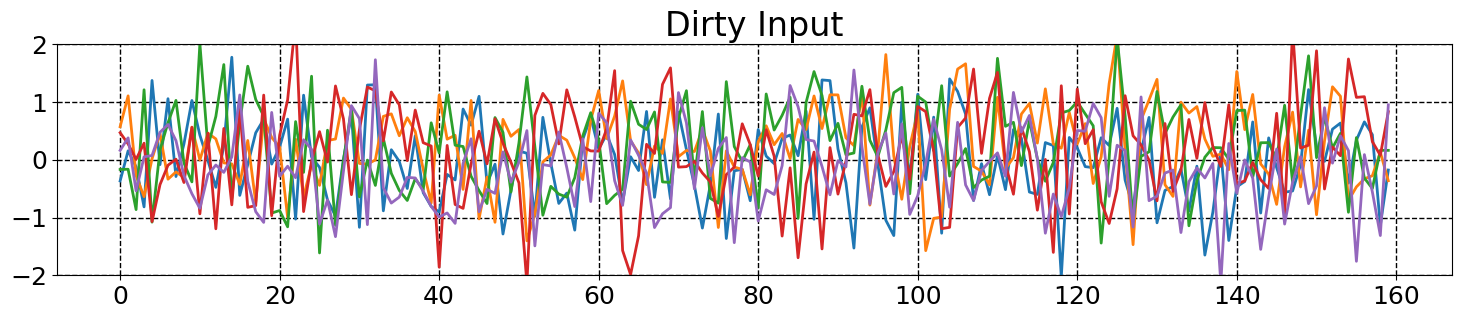

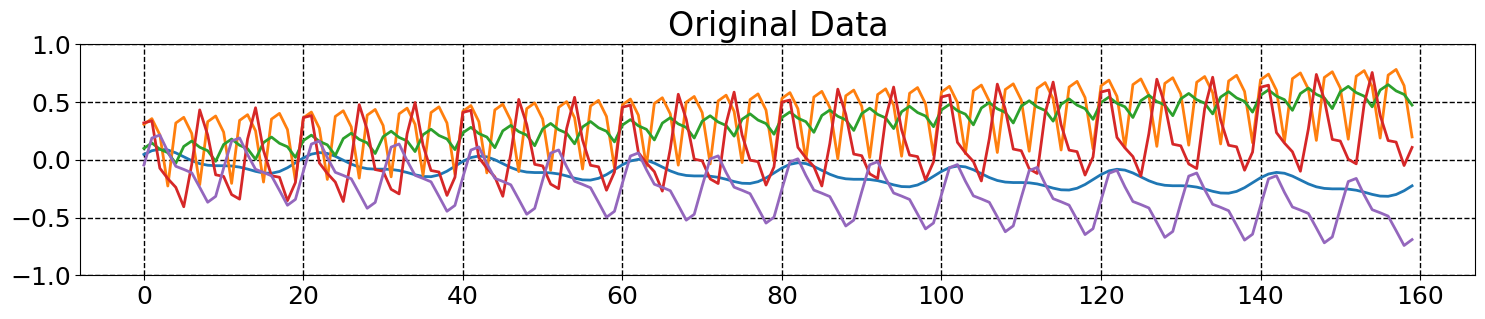

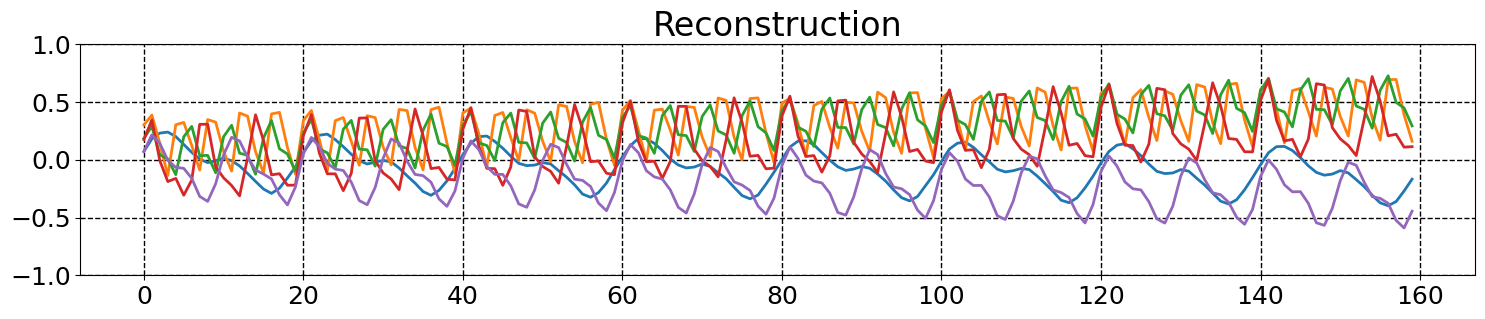

In [9]:
idx, size = 0, 5
dir = f'./OUTPUT/figures/fig_{t}'
os.makedirs(dir, exist_ok=True)

plt.figure(figsize=(18, 3))
for i in range(size):
    plt.plot(x[idx, :, -i].cpu().flatten(), lw=2)
plt.grid(color='k', ls ='--', lw=1)
plt.title('Dirty Input', fontsize=24)
plt.tick_params('both', labelsize=18)
plt.ylim((-2, 2))
plt.show()

plt.figure(figsize=(18, 3))
for i in range(size):
    plt.plot(data[idx, :, -i].cpu().flatten(), lw=2)
plt.grid(color='k', ls ='--', lw=1)
plt.title('Original Data', fontsize=24)
plt.tick_params('both', labelsize=18)
plt.ylim((-1, 1))
plt.show()

plt.figure(figsize=(18, 3))
for i in range(size):
    plt.plot((trend + season + r)[idx, :, -i].cpu().detach().numpy().flatten(), lw=2)
plt.grid(color='k', ls ='--', lw=1)
plt.title('Reconstruction', fontsize=24)
plt.tick_params('both', labelsize=18)
plt.ylim((-1, 1))
plt.show()

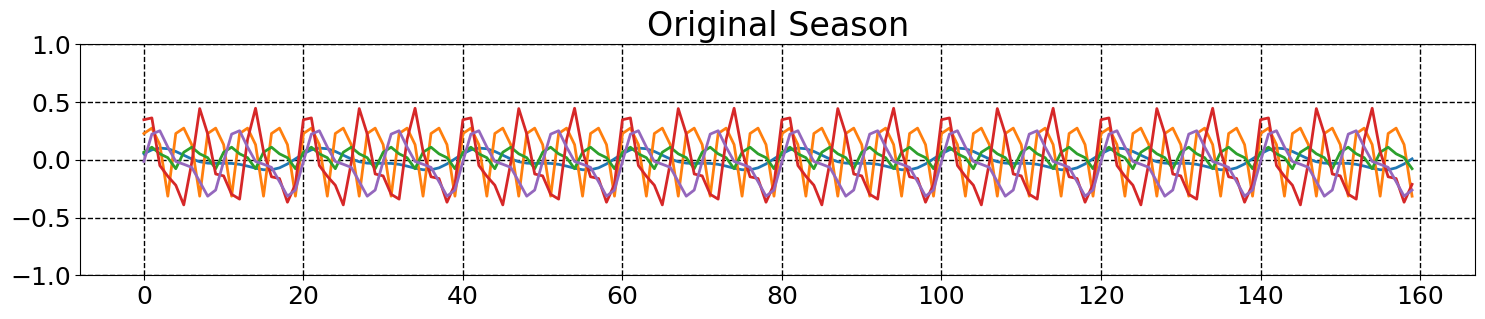

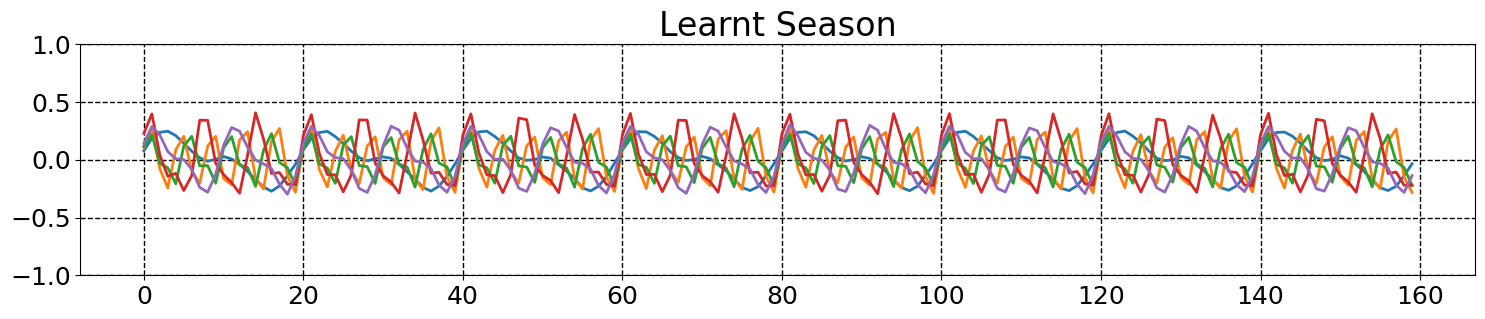

In [10]:
plt.figure(figsize=(18, 3))
for i in range(size):
    plt.plot(season_r[idx, :, -i].cpu().flatten(), lw=2)
plt.grid(color='k', ls ='--', lw=1)
plt.title('Original Season', fontsize=24)
plt.tick_params('both', labelsize=18)
plt.ylim((-1, 1))
plt.show()

plt.figure(figsize=(18, 3))
for i in range(size):
    plt.plot(season[idx, :, -i].cpu().detach().numpy().flatten(), lw=2)
plt.grid(color='k', ls ='--', lw=1)
plt.title('Learnt Season', fontsize=24)
plt.tick_params('both', labelsize=18)
plt.ylim((-1, 1))
plt.show()

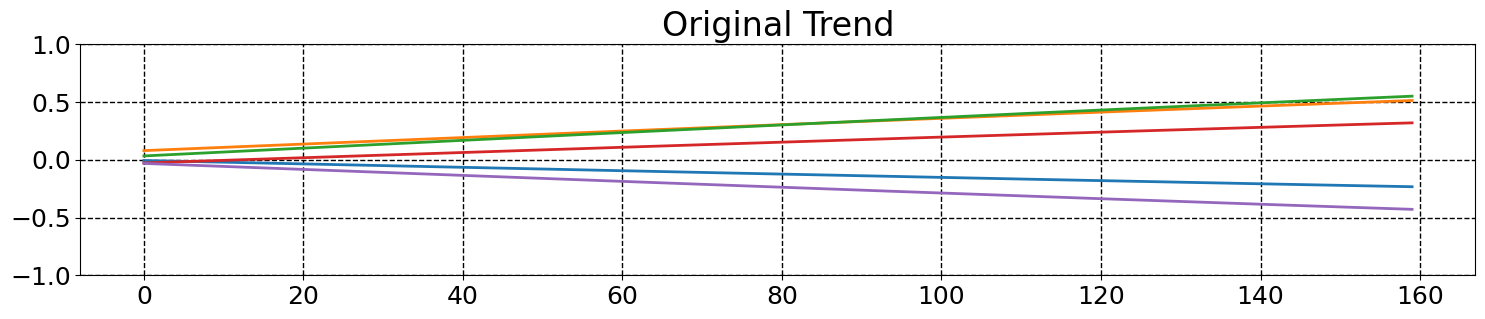

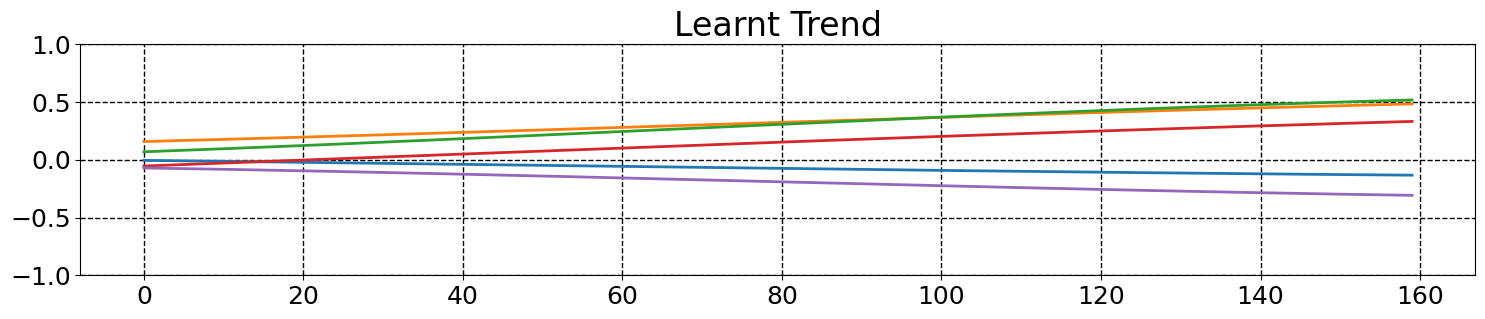

In [11]:
plt.figure(figsize=(18, 3))
for i in range(size):
    plt.plot(trend_r[idx, :, -i].cpu().flatten(), lw=2)
plt.grid(color='k', ls ='--', lw=1)
plt.title('Original Trend', fontsize=24)
plt.tick_params('both', labelsize=18)
plt.ylim((-1, 1))
plt.show()

plt.figure(figsize=(18, 3))
for i in range(size):
    plt.plot(trend[idx, :, -i].cpu().detach().numpy().flatten(), lw=2)
plt.grid(color='k', ls ='--', lw=1)
plt.title('Learnt Trend', fontsize=24)
plt.tick_params('both', labelsize=18)
plt.ylim((-1, 1))
plt.show()

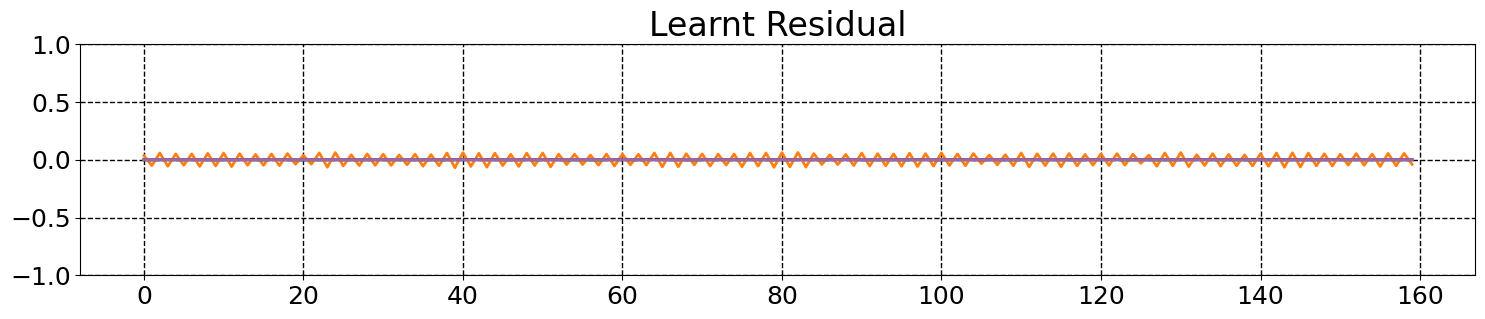

In [12]:
plt.figure(figsize=(18, 3))
for i in range(size):
    plt.plot(r[idx, :, -i].cpu().detach().numpy().flatten(), lw=2)
plt.grid(color='k', ls ='--', lw=1)
plt.title('Learnt Residual', fontsize=24)
plt.tick_params('both', labelsize=18)
plt.ylim((-1, 1))
plt.show()